# Generate assets for scaling up video generation

We have seen how we can generate videos from audio files. Let's scale up our production now. We need more audio files and new faces.

First, let's fetch some sample audio recording from the [Common Voice dataset](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0) by the Mozilla Foundation.

In [2]:
import os

from datasets import load_dataset
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")
CACHE_DIR = os.getenv("CACHE_DIR")
login(token=HF_TOKEN)

common_voice_en = load_dataset(
    "mozilla-foundation/common_voice_17_0", "en",
    split="test",
    cache_dir=CACHE_DIR,
    streaming=True
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


In [3]:
def generate_audio():
    for sample in common_voice_en:
        if sample["gender"] in ["male_masculine", "female_feminine"]:
            yield (
                sample["audio"]["array"],
                sample["audio"]["sampling_rate"],
                "male" if sample["gender"] == "male_masculine" else "female"
            )


In [4]:
from IPython.display import Audio

sample_audio, sampling_rate, gender = next(generate_audio())
Audio(sample_audio, rate=sampling_rate)

Reading metadata...: 0it [00:00, ?it/s]

Reading metadata...: 16393it [00:00, 34322.07it/s]


Let's write now the audio to file to be used for the video generation.

In [5]:
from scipy.io import wavfile

wavfile.write(f'./audio/sample_audio_{gender}.wav', sampling_rate, sample_audio)

Now we need to generate a new face. We will use a leading open source model for text-to-image: Stable Difussion 3 Medium model.



In [8]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.29.0",
  "_name_or_path": "stabilityai/stable-diffusion-3-medium-diffusers",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [15]:
prompt = "man" if gender == "male" else "woman" + \
" looking at the camera, casually dressed, flat background, uniform lighting"
image = pipe(
    prompt=prompt,
    num_inference_steps=28,
    height=1024,
    width=1024,
    guidance_scale=7.0,
).images[0]


 46%|████▋     | 13/28 [00:01<00:02,  6.94it/s]Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.


100%|██████████| 28/28 [00:04<00:00,  6.90it/s]


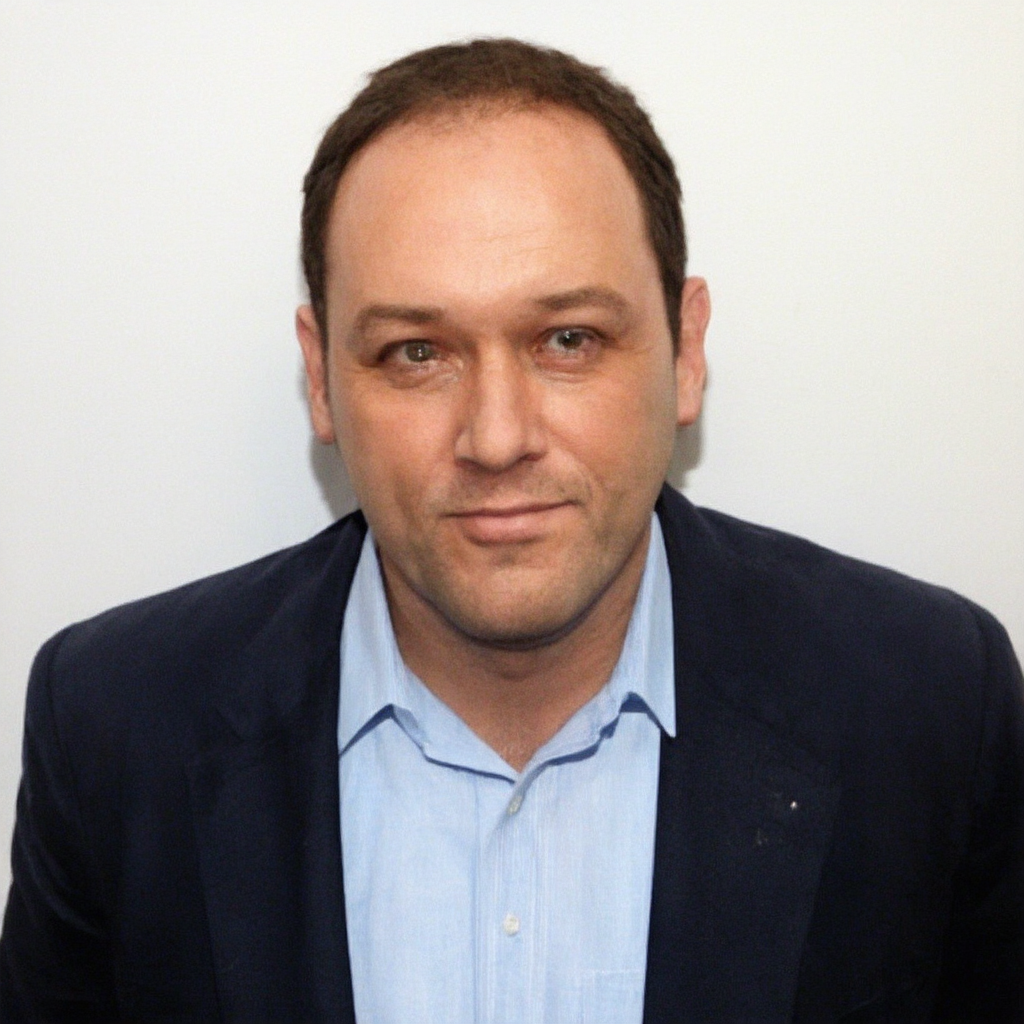

In [10]:
from IPython.display import display

display(image)

In [11]:

image.save(f"./img/sample_{gender}.jpg")